In [1]:
from basicgeo import P2, P3
from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)
# approximately flat and in metres (based around section 7) without the compression at the leading edge    
#parapolygraph = ParamPolyGraph(wingshape, "segmentedwing.txt", deprecatedTrimFile=True)
#parapolygraph.saveas("test.json")
parapolygraph = ParamPolyGraph(wingshape, "test.json")


Parametrization in uv:  (0, 6.11206792886613) (-1.377293405726668, 1.377293405726668)


<IPython.core.display.Javascript object>


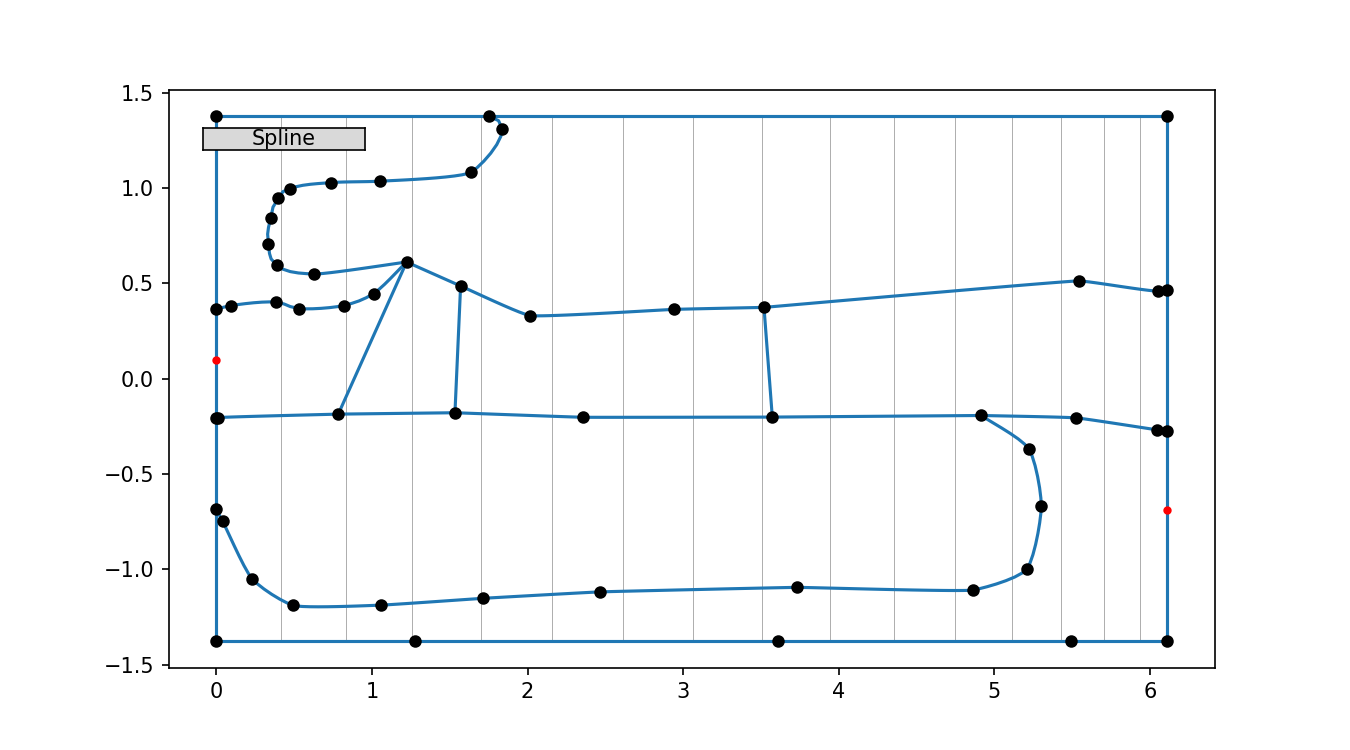

In [2]:
%matplotlib notebook

from matplotlib import pyplot as plt
import interactiveuvpara

fig = plt.figure(figsize=(9,5))
interactiveuvpara.makeinteractivefigure(fig, parapolygraph)
plt.show()

In [3]:
parapolygraph.saveas("test.json")


<IPython.core.display.Javascript object>


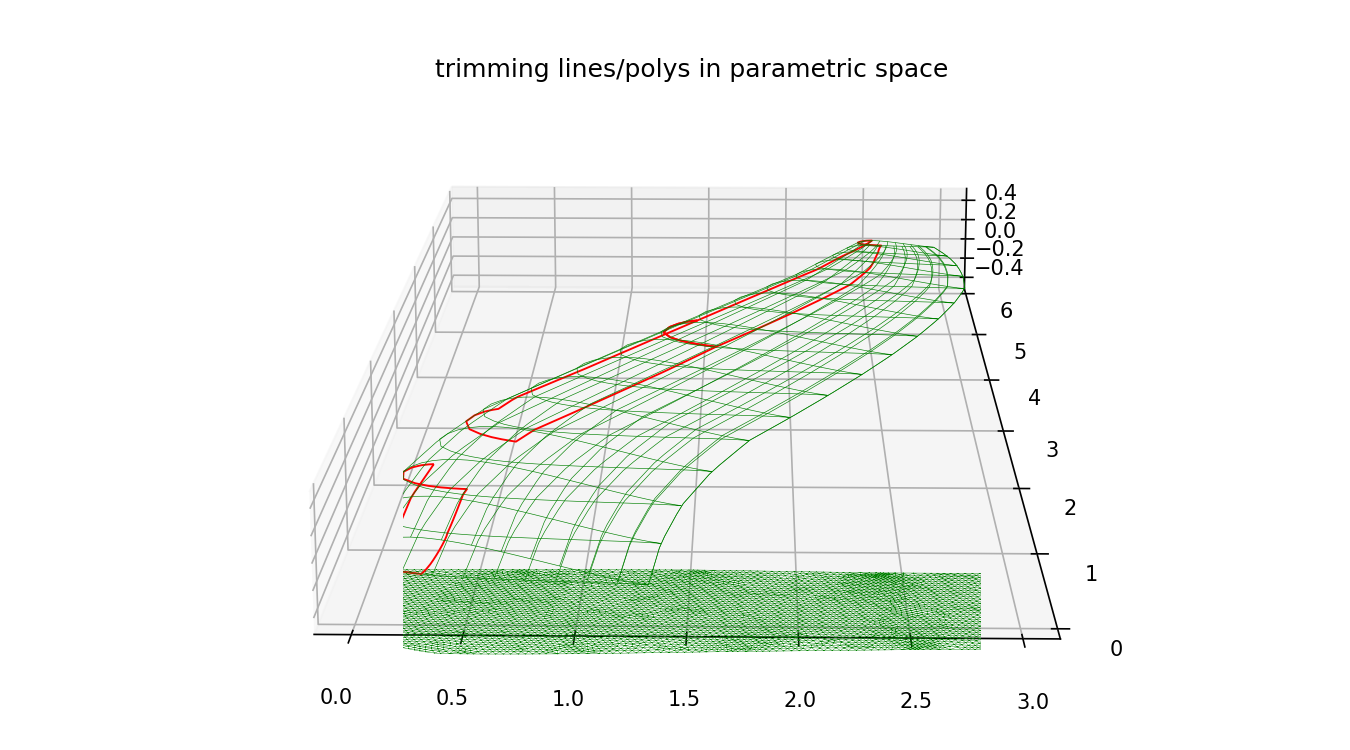

(0.0, 6.0)

In [2]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return P3(p.x, p.z, p.y)

parapolygraph.splineinterplegsdata()

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

seglines = [ [flipyz(wingshape.seval(P2(u,v)))  for v in numpy.linspace(wingshape.vrange[0], wingshape.vrange[1], 51)]  for u in wingshape.leadingedgelengths ]
spanlines = [ [flipyz(wingshape.seval(P2(u,v)))  for u in numpy.linspace(wingshape.urange[0], wingshape.urange[1], 51)]  for v in numpy.linspace(wingshape.vrange[0], wingshape.vrange[1], 21) ]
lc3d = Line3DCollection(seglines+spanlines, color="green", linewidth=0.3)
ax3d.add_collection(lc3d)

polysnodes = parapolygraph.derivepolygons()
segpolys = [ ]
for k in [0, 4, 2]:
    polyloop = parapolygraph.splinedpolypoints(polysnodes[k])
    segpolys.append([flipyz(wingshape.seval(p))  for p in polyloop])
    segpolys[-1].append(segpolys[-1][0])
lp3d = Line3DCollection(segpolys, color="red", linewidth=0.9)
ax3d.add_collection(lp3d)

ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)

<IPython.core.display.Javascript object>


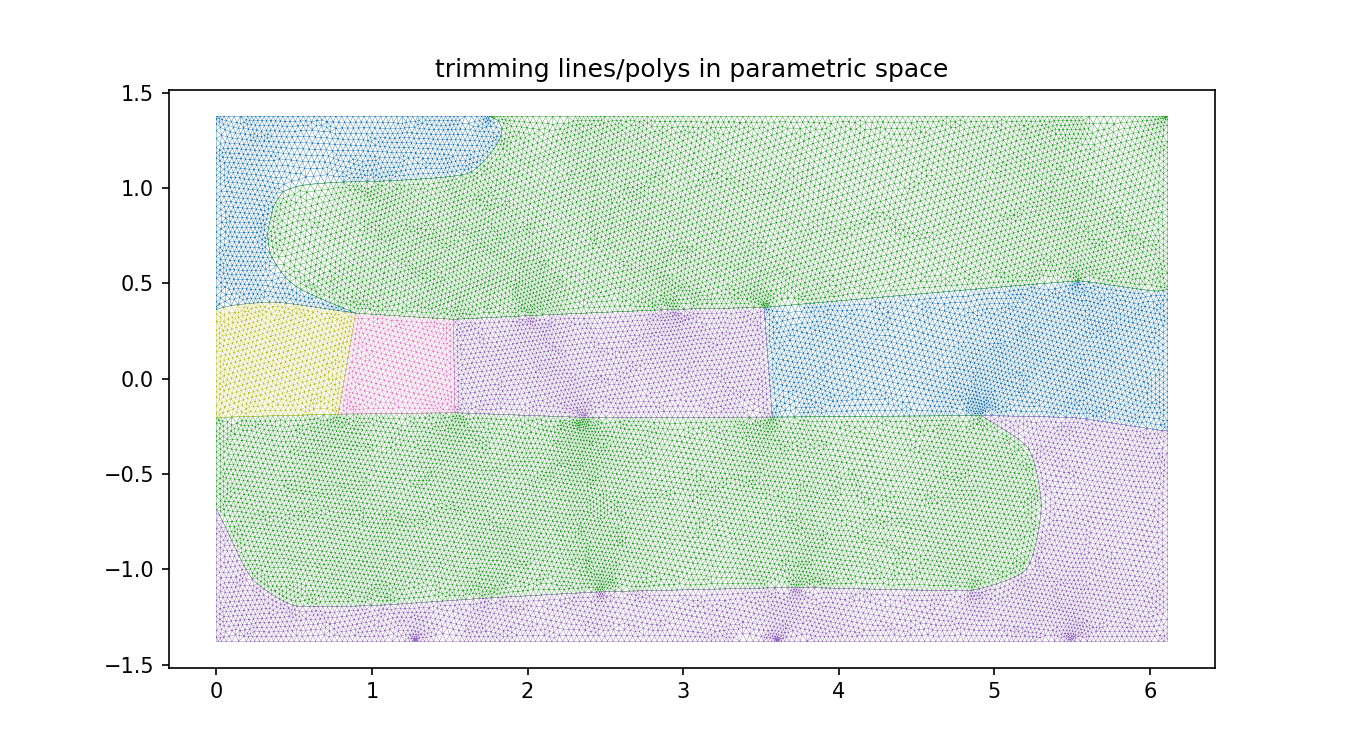

In [21]:
import pygmsh, numpy

def surfacemesheslist(polysnodes, mesh_size):
    surfacemeshes = [ ]
    for polynodes in polysnodes:
        polyloop = parapolygraph.splinedpolypoints(polynodes)
        with pygmsh.geo.Geometry() as g:
            g.add_polygon(polyloop, mesh_size=mesh_size)
            mesh = g.generate_mesh()
        pts = numpy.array([ wingshape.seval(p)  for p in mesh.points ])
        surfacemesh = { "polynodes":polynodes, 
                        "uvpts":mesh.points, 
                        "pts":numpy.array(pts),
                        "tris":mesh.cells_dict["triangle"]
                      }
        surfacemeshes.append(surfacemesh)
    return surfacemeshes

surfacemeshes = surfacemesheslist(polysnodes, 0.05)

fig = plt.figure(figsize=(9,5))
for surfacemesh in surfacemeshes:
    uvpts = surfacemesh["uvpts"]
    plt.triplot(uvpts[:,0], uvpts[:,1], surfacemesh["tris"], linewidth=0.2)
plt.title("trimming lines/polys in parametric space");


<IPython.core.display.Javascript object>


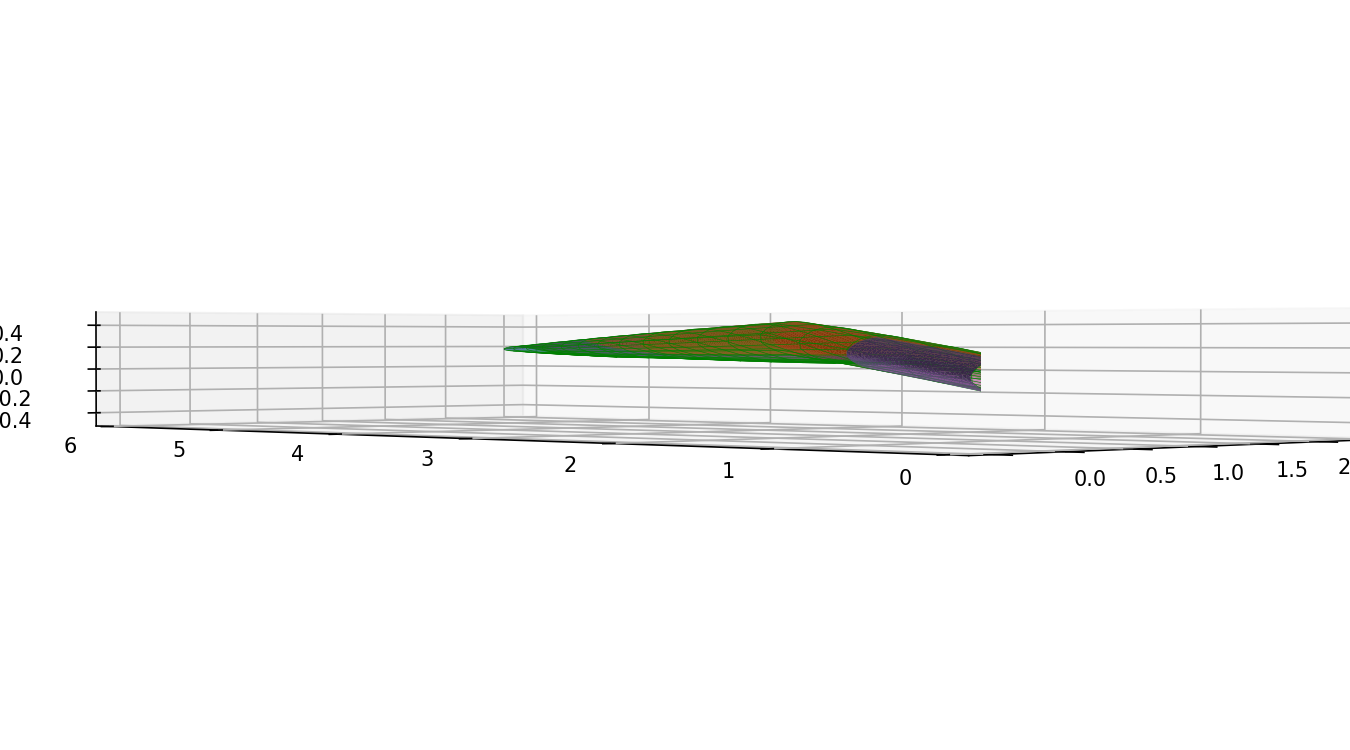

(0.0, 6.0)

In [22]:
import numpy
fig = plt.figure(figsize=(9,5))


ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)
lc3db = Line3DCollection(seglines+spanlines, color="green", linewidth=0.3)
ax3d.add_collection(lc3db)

for surfacemesh in surfacemeshes:
    pts = surfacemesh["pts"]
    ax3d.plot_trisurf(pts[:,0], pts[:,2], Z=pts[:,1], triangles=surfacemesh["tris"])

ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)

1013

In [107]:
import subprocess, json

freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"
# fetch from: wget https://github.com/FreeCAD/FreeCAD/releases/download/0.19_pre/FreeCAD_0.19-24267-Linux-Conda_glibc2.12-x86_64.AppImage
freecadappimage = "freecad"   # nixos install

def trimeshesflattener(surfacemeshes):
    surfacemeshfile = "surfacemeshfile.json"
    flatmeshfile = "flattenedmesh.json"

    if os.path.exists(flatmeshfile):
        os.remove(flatmeshfile)

    jsurfacemeshes = [ { "pts":surfacemesh["pts"].tolist(), "tris":surfacemesh["tris"].tolist() }\
                          for surfacemesh in surfacemeshes ]
    json.dump(jsurfacemeshes, open(surfacemeshfile, "w"))


    fccode = """import flatmesh
import sys, numpy, json, os

surfacemeshfile = "%s"
flatmeshfile = "%s"
scaleupunits = 1024.0
surfacemeshes = json.load(open(surfacemeshfile))
flatmeshespts = [ ]
for surfacemesh in surfacemeshes:
    pts = scaleupunits*numpy.array(surfacemesh["pts"])
    tris = numpy.array(surfacemesh["tris"])
    flattener = flatmesh.FaceUnwrapper(pts, tris)
    flattener.findFlatNodes(10, 0.95)
    fnodes = (1.0/scaleupunits)*numpy.array(flattener.ze_nodes)
    print("mesh (pts=%%d, tris=%%d) flattened" %% (len(pts), len(tris)))
    flatmeshespts.append(fnodes.tolist())

json.dump(flatmeshespts, open(flatmeshfile, "w"))
""" % (surfacemeshfile, flatmeshfile)

    a = subprocess.run([freecadappimage, "-c"], input=fccode.encode(), capture_output=True)
    print(a.stderr.decode())
    print(a.stdout.decode())
    flatmeshes = json.load(open(flatmeshfile))
    for i, flatmesh in enumerate(flatmeshes):
        surfacemeshes[i]["fpts"] = numpy.array(flatmesh)



>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> 
>>> 

[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
mesh (pts=2367, tris=4530) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



In [113]:
trimeshesflattener(surfacemeshes)


>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> 
>>> 

[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
mesh (pts=2367, tris=4530) flattened
mesh (pts=7343, tris=14308) flattened
mesh (pts=1705, tris=3246) flattened
mesh (pts=505, tris=930) flattened
mesh (pts=696, tris=1303) flattened
mesh (pts=1187, tris=2183) flattened
mesh (pts=6672, tris=12937) flattened
mesh (pts=3456, tris=6419) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



<IPython.core.display.Javascript object>


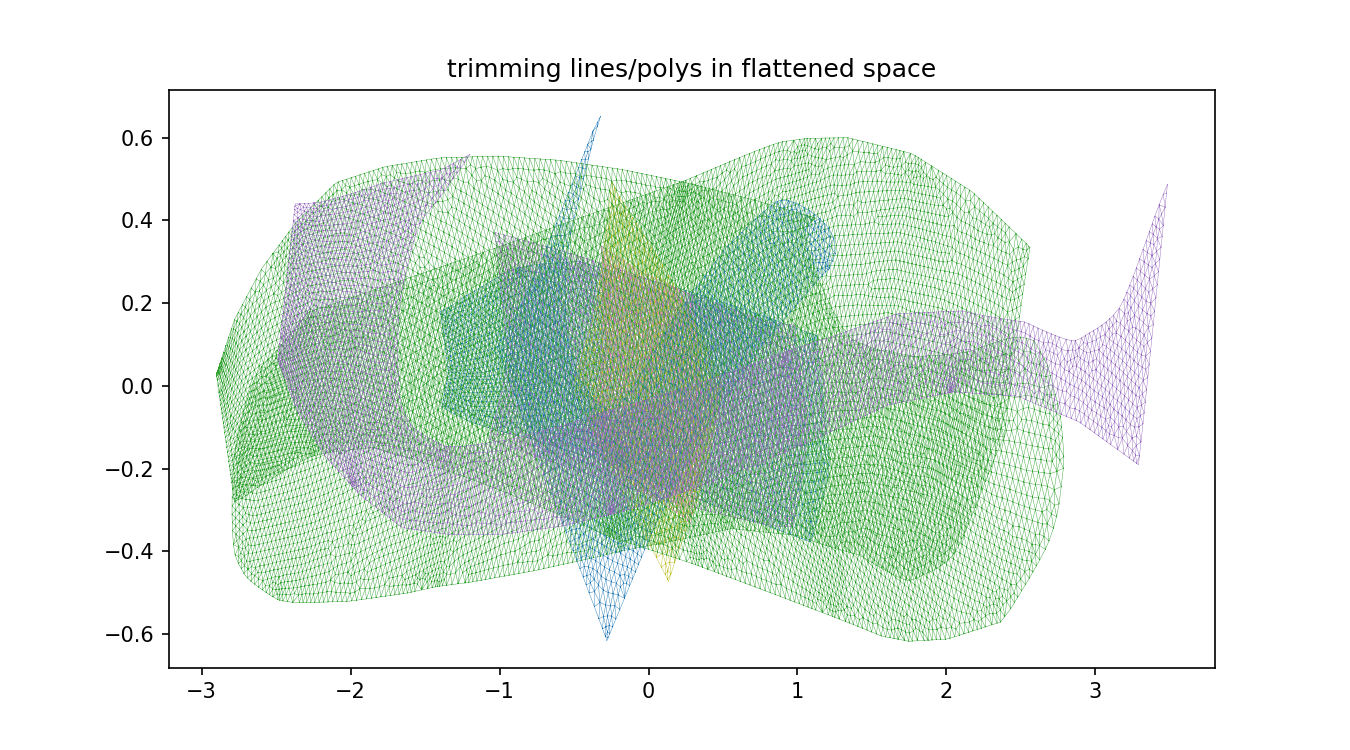

In [115]:
fig = plt.figure(figsize=(9,5))
for surfacemesh in surfacemeshes:
    uvpts = surfacemesh["uvpts"]
    fpts = surfacemesh["fpts"]
    #plt.triplot(uvpts[:,0], uvpts[:,1], surfacemesh["tris"], linewidth=0.2)
    plt.triplot(fpts[:,0], fpts[:,1], surfacemesh["tris"], linewidth=0.2)
    plt.title("trimming lines/polys in flattened space");
